In [34]:
import sys, os, path
import numpy as np
import torch as th
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans/scripts/')
from utilities import get_invariants, get_tensor_functions

In [35]:
train_data_path = '/home/leonriccius/Documents/Fluid_Data/training_data/periodic_hills'
# on workstation: home/leon/Master_Thesis/Fluid_Data ...
rans_time = '1500'

In [36]:
cases = os.listdir(os.sep.join([train_data_path, 'tensordata']))
print(cases)

['2800', '1400', '700', '5600', '10595']


In [37]:
# funcion of the bottom boundary
# characteristic points
x = (1.929/54) * np.array([0., 0.1, 9., 14., 20., 30., 40., 53.9, 54.])
x = np.append(x, 9 - x[::-1])
y = (1.929/54) * np.array([28., 28., 27., 24., 19., 11., 4., 0., 0.])
y = np.append(y, y[::-1])

# spline interpolation
f_bottom = interp1d(x, y, kind='cubic', fill_value='extrapolate')

In [38]:
# function to create mask for points selection
def mask_boundary_points(x, y, blthickness = 0.15):
    mask = np.ones(x.shape, dtype=bool)
    y_interp = f_bottom(x)
    mask[np.where(y < y_interp + blthickness)] = False
    mask[np.where(y > 3.035 - blthickness)] = False
    mask[np.where(x < 0. + blthickness)] = False
    mask[np.where(x > 9. - blthickness)] = False
    return mask

In [39]:
# define grid for interpolation
grid_x, grid_y = np.mgrid[0.:9.:150j, 0.:3.05:50j]
grid = th.tensor([grid_x.flatten(), grid_y.flatten()]).T

# get mask for points selection
mask = mask_boundary_points(grid_x.flatten(), grid_y.flatten())

In [40]:
# loop for rans data
for case in cases:
    # define current path and read in data
    curr_case = os.sep.join([train_data_path, 'rans', case, rans_time])
    rs_rans = th.load(os.sep.join([curr_case, 'RS-torch.th']))
    s = th.load(os.sep.join([curr_case, 'S-torch.th']))
    r = th.load(os.sep.join([curr_case, 'R-torch.th']))
    epsilon0 = th.load(os.sep.join([curr_case, 'epsilon-torch.th']))
    k0 = th.load(os.sep.join([curr_case, 'k-torch.th']))
    cellCenters = th.load(os.sep.join([curr_case, 'cellCenters-torch.th']))[:,0:2]
    
    # expand k
    k = k0.unsqueeze(0).unsqueeze(0).expand(3,3,k0.size()[0])
    k = k.permute(2, 0, 1)
    
    # expand epsilon
    epsilon = epsilon0.unsqueeze(0).unsqueeze(0).expand(3,3,epsilon0.size()[0])
    epsilon = epsilon.permute(2, 0, 1)
    
    # normalize S and R
    s_hat = k/epsilon*s
    r_hat = k/epsilon*r
    
    # compute invariants and basis tensors
    inv = get_invariants(s_hat, r_hat)
    T = get_tensor_functions(s_hat, r_hat)
    
    # compute anisotropy tensor b
    b_rans = rs_rans/(2*k) - 1/3 * th.eye(3).unsqueeze(0).expand(k0.shape[0],3,3)
    
    # interpolate inv, T
    inv_interp = th.tensor(griddata(cellCenters, inv, (grid_x, grid_y), method='linear')).flatten(end_dim = 1)
    T_interp = th.tensor(griddata(cellCenters, T, (grid_x, grid_y), method='linear')).flatten(end_dim = 1)
    b_rans_interp = th.tensor(griddata(cellCenters, b_rans, (grid_x, grid_y), method='linear')).flatten(end_dim = 1)
    grid_interp = th.tensor([grid_x.flatten(), grid_y.flatten()]).T
    
    # remove points close to boundary
    inv_interp = inv_interp[mask]
    T_interp = T_interp[mask]
    grid_interp = grid[mask]
    b_rans_interp = b_rans_interp[mask]
    
    # store inv, T, grid
    storage_path = os.sep.join([train_data_path, 'tensordata', case])
#     th.save(inv_interp, os.sep.join([storage_path, 'inv-torch.th']))
#     th.save(T_interp, os.sep.join([storage_path, 'T-torch.th']))
#     th.save(b_rans_interp, os.sep.join([storage_path, 'b_rans-torch.th']))
#     th.save(grid_interp, os.sep.join([storage_path, 'grid-torch.th']))

In [29]:
# loop for DNS data
for case in cases:
    # define current path and read in data
    curr_case = os.sep.join([train_data_path, 'dns', case])
    data = np.loadtxt(os.sep.join([curr_case, 'ASCII_Breuer.dat']), skiprows=16)
    
    # get shape of data
    N, M = data.shape
    
    # extract relevant data from dataset
    rs_dns = th.tensor(np.array([data[:,6], data[:,9], np.full(N,0),
                                data[:,9], data[:,7], np.full(N,0),
                                np.full(N,0), np.full(N,0), data[:,8]]).T.reshape(-1,3,3))
    cellCenters = th.tensor([data[:,0],data[:,1]]).T
    k0 = 0.5*th.from_numpy(rs_dns.numpy().trace(axis1 = 1, axis2 = 2))
    
    # expand k
    k = k0.unsqueeze(0).unsqueeze(0).expand(3,3,k0.shape[0])
    k = k.permute(2, 0, 1)

    # compute anisotropy tensor b
    b_dns = rs_dns/(2*k) - 1/3 * th.eye(3).unsqueeze(0).expand(k0.shape[0],3,3)
    
    # interpolate b
    b_dns_interp = th.tensor(griddata(cellCenters, b_dns, (grid_x, grid_y), method='linear')).flatten(end_dim = 1)
    
    # remove points close to boundary
    b_dns_interp = b_dns_interp[mask]
    
    # save b
    storage_path = os.sep.join([train_data_path, 'tensordata', case])
#     th.save(b_dns_interp, os.sep.join([storage_path, 'b_dns-torch.th']))

In [9]:
# grid_x, grid_y = np.mgrid[0.:9.:90j, 0.:3.05:30j]

In [10]:
mask = mask_boundary_points(grid_x.flatten(), grid_y.flatten())
grid_x_cut, grid_y_cut = (grid_x.flatten()[mask], grid_y.flatten()[mask])

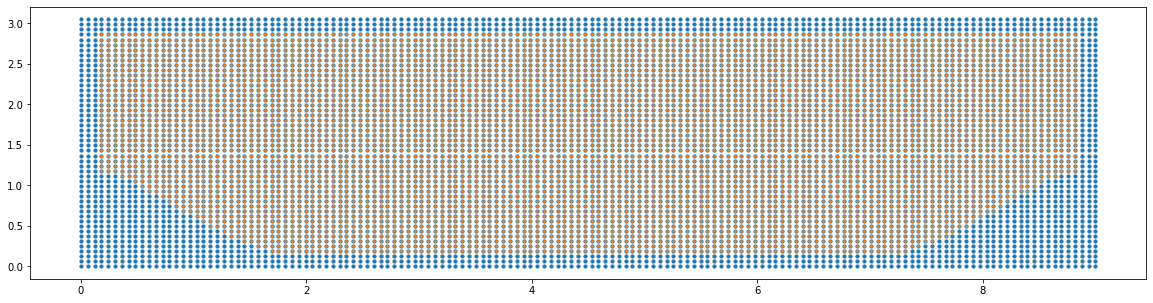

In [11]:
fig, ax = plt.subplots(figsize=(20,5))

ax.scatter(grid_x, grid_y, s=10)
ax.scatter(grid_x_cut, grid_y_cut,s=3)

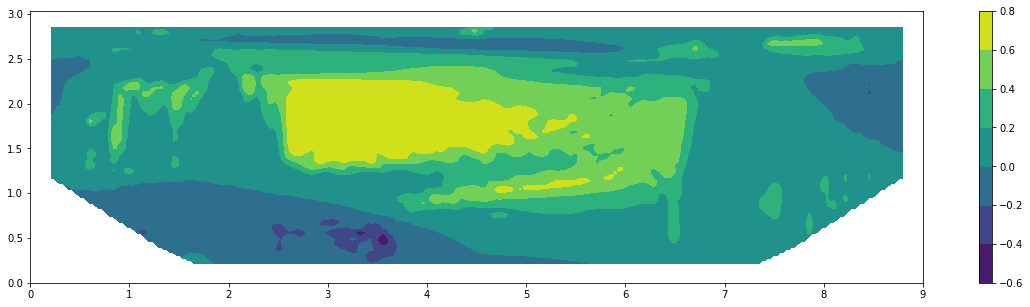

In [33]:
grid_all_x, grid_all_y = np.mgrid[0.:9.:300j, 0.:3.035:100j]
grid_all_z1 = griddata(grid_interp, T_interp[:,4,2,1], (grid_all_x, grid_all_y), method='linear') # inv[:,1]

fig, ax = plt.subplots(figsize=(20,5))
DNS_all_domain = ax.contourf(grid_all_x, grid_all_y, grid_all_z1)
fig.colorbar(DNS_all_domain, ax=ax)

In [13]:
b_interp.shape

torch.Size([5908, 3, 3])